<a href="https://colab.research.google.com/github/gunahn/ML4Mindfulness_Autism/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Packages**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [3]:
# downgrading of xgboost from 3.1.1 to 3.0.5
!pip uninstall -y xgboost
!pip install xgboost==3.0.5

Found existing installation: xgboost 3.1.1
Uninstalling xgboost-3.1.1:
  Successfully uninstalled xgboost-3.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 8.6 MB/s eta 0:00:00


In [4]:
#Loading other packages
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st

import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import re

from sklearn.model_selection import KFold, RepeatedKFold
from scipy.stats import pearsonr, ConstantInputWarning, NearConstantInputWarning
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=ConstantInputWarning)
warnings.filterwarnings("ignore", category=NearConstantInputWarning)

In [5]:
xgb.__version__

'3.0.5'

In [6]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

# **Data Prep**

In [7]:
y_state = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/y_state.csv")
y_trait = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/y_trait.csv")
X = pd.read_csv("/content/drive/MyDrive/Mindful_Inter_Autism_Data/X.csv")

In [8]:
y_state = np.ravel(y_state)
y_trait = np.ravel(y_trait)

In [9]:
scale_cols = [
        'STAI_Baseline_STATE', 'STAI_Baseline_TRAIT', 'Promis_Total_Raw', 'PSS_Total_Score', 'Panas_Positive_Affect_Score', 'Panas_Negative_Affect_Score',
        'Maas_Raw_Score', 'Maas_Mean', 'FFMQ_Total_RAW_Score_with_Observation_subscale_', 'FFMQ_Total_Score_including_Observation_subscale_Mean',
        'FFMQ_Total_RAW_score_Excluding_Observation_Subscale_', 'FFMQ_Total_Score_excluding_Observation_subscale_Mean', 'FFMQ_Observation_subscale_Mean',
        'FFMQ_Description_Subscale_Mean', 'FFMQ_Acting_with_Awareness_Subscale_Mean', 'FFMQ_Non-judgemental_Mean', 'FFMQ_Non-reactivity_Mean',
        'Age', 'AQ_baseline', 'TMB_base', 'LC_baseline']

scaler = StandardScaler()

def Standardize_data(X_train, X_test):
  tr_scaled = X_train.copy()
  test_scaled = X_test.copy()

  tr_scaled[scale_cols] = scaler.fit_transform(tr_scaled[scale_cols])
  test_scaled[scale_cols] = scaler.transform(test_scaled[scale_cols])

  return tr_scaled, test_scaled

# ---

---



# **STATE w/ Pipeline + GridSearch CV**

In [ ]:
def RepeatedInnerLoop(X_train, X_valid, y_train, random_state=1):
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaled', StandardScaler(), scale_cols),  # scale_cols - scaling
        ],
        remainder='passthrough'
    )
    # Inner CV: Cross Validation with GridSearchCV
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    model = xgb.XGBClassifier(objective='binary:logistic',
                                seed=1,
                                eval_metric = 'auc',
                                n_estimators = 1000)
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    # define search space
    param_grid = {'model__max_depth': [3, 5, 7],
      'model__learning_rate': [0.01, 0.05, 0.01],
      'model__gamma': [0, 0.1, 0.05],
      'model__reg_lambda': [0, 0.1, 0.05],
      'model__reg_alpha': [0, 0.1, 0.05]}

    # define search
    search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=1, cv=cv_inner, refit=True)

    # Inner Loop: GridSearchCV to find best parameters
    search.fit(X_train, y_train)

    # Evaluate on the outer loop
    y_pred = search.predict(X_valid)
    return y_pred, search

def NestedCV(X, y):
    # Outer CV: Validation with KFold
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1+30)
    outer_results = list()

    # Nested CV
    # Initialize best_est list here before the loop

    for train_index, valid_index in cv_outer.split(X, y):
        X_tr, X_test = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_test = y[train_index], y[valid_index]

        y_pred, search = RepeatedInnerLoop(X_tr, X_test, y_tr, random_state=1)
        best_param = search.best_params_
        best_est.append(search.best_estimator_)

        auc_score = roc_auc_score(y_test, y_pred)
        outer_results.append(auc_score)


        print(f"Best Param: {best_param}, AUC Score: {auc_score:.4f}")

    auc_mean_score = np.mean(outer_results)
    auc_std_score = np.std(outer_results)

    print(f"[Overall] Nested CV AUC: {auc_mean_score:.4f} ± {auc_std_score:.4f}")
    print('--'*100)

In [ ]:
best_est = [] #run time 45 minutes
NestedCV(X, y_state)

KeyboardInterrupt: 

potential model? 'model__gamma': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1}, AUC Score: 0.8571

In [ ]:
aucs = []
n_folds = 5
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for estimator in best_est:
    for train_index, valid_index in cv_inner.split(X, y_state):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y_state[train_index], y_state[valid_index]

        X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

        model = estimator.named_steps['model']
        model.fit(X_tr_scaled, y_tr)
        pred = model.predict(X_val_scaled)
        pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc_score = roc_auc_score(y_val, pred_proba)

        aucs.append(auc_score)
    avg_auc = sum(aucs) / len(aucs)
    stdev = np.std(aucs)

    # 95% confidence interval using t-distribution
    ci_low, ci_high = st.t.interval(0.95,
        df=n_folds - 1,
        loc=avg_auc,
        scale=stdev / np.sqrt(n_folds)
    )

    print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    aucs.clear()

AUC = 0.7148 | Stdev = 0.1547 | 95% CI = [0.5227, 0.9070]
AUC = 0.6970 | Stdev = 0.1425 | 95% CI = [0.5201, 0.8740]
AUC = 0.7067 | Stdev = 0.1468 | 95% CI = [0.5244, 0.8889]
AUC = 0.7096 | Stdev = 0.1659 | 95% CI = [0.5037, 0.9156]
AUC = 0.7104 | Stdev = 0.1732 | 95% CI = [0.4954, 0.9254]
AUC = 0.7074 | Stdev = 0.1317 | 95% CI = [0.5439, 0.8709]
AUC = 0.6963 | Stdev = 0.1362 | 95% CI = [0.5272, 0.8654]
AUC = 0.7081 | Stdev = 0.1509 | 95% CI = [0.5207, 0.8955]
AUC = 0.6911 | Stdev = 0.1441 | 95% CI = [0.5122, 0.8700]
AUC = 0.7267 | Stdev = 0.1577 | 95% CI = [0.5309, 0.9224]


## model 10

## **Aggregate Feature Importances**

In [ ]:
aucs = []
feature_names = X.columns
counter = 0
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    # xgb_model = best_est[9].named_steps['model']
    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1,
                                  gamma= 0,
                                  learning_rate=0.05,
                                  max_depth= 5,
                                  reg_alpha=0,
                                  reg_lambda=0.05,
                                  eval_metric = 'auc',
                                  n_estimators = 1000)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)
    pred = xgb_model.predict(X_val_scaled)
    pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, pred_proba)

    aucs.append(auc_score)

    # feature importances
    importances = xgb_model.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

avg_auc = sum(aucs) / len(aucs)
stdev = np.std(aucs)
aucs.clear()

In [ ]:
n_folds = 5

# 95% confidence interval using t-distribution
ci_low, ci_high = st.t.interval(
    0.95,
    df=n_folds - 1,
    loc=avg_auc,
    scale=stdev / np.sqrt(n_folds)
)

# print(f"{best_est[9].named_steps['model']}")
print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")

AUC = 0.7267 | Stdev = 0.1577 | 95% CI = [0.5309, 0.9224]


In [ ]:
fi_df_copy = fi_df.copy()

fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = fi_df_copy.sort_values(by=['importances'], ascending=False).head(10)
# save_to_drive.to_csv('/content/drive/MyDrive/Mindful_Inter_Autism_Data/Feature Importances/XGB_STATE_fi.csv', index=True)
save_to_drive

/tmp/ipython-input-305386325.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_17,0.164509
STAI_1,0.146273
STAI_20,0.139492
PSS_6,0.105761
STAI_19,0.096496
STAI_13,0.092685
AQ3,0.091856
FFMQ_6,0.086412
AQ32,0.081919
STAI_30,0.081787


## **Calibration Curve**

In [ ]:
xgb_kfold_probability = []
true_labels = []

from sklearn.calibration import calibration_curve
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1,
                                  gamma= 0,
                                  learning_rate=0.05,
                                  max_depth= 5,
                                  reg_alpha=0,
                                  reg_lambda=0.05,
                                  eval_metric = 'auc',
                                  n_estimators = 1000)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)
    pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
    xgb_kfold_probability.append(pred_proba)
    true_labels.append(y_val)

    # Compute the calibration curve using 10 bins.
    mean_predicted_value, true_fraction_of_positives = calibration_curve(
        y_val,
        pred_proba,
        n_bins=20,
        strategy="uniform",
    )


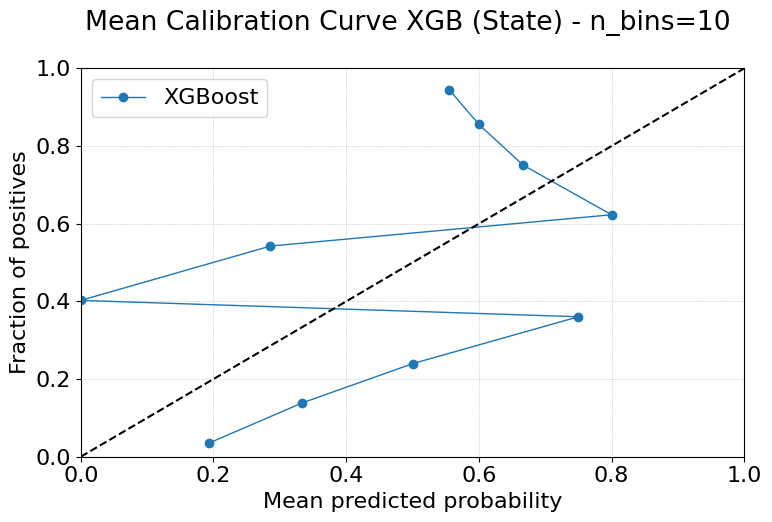

In [ ]:
xgb_kfold_probability_stacked = np.hstack(xgb_kfold_probability)
true_labels_stacked = np.hstack(true_labels)
xgb_y, xgb_x = calibration_curve(true_labels_stacked, xgb_kfold_probability_stacked, n_bins=10)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(xgb_y, xgb_x, marker='o', linewidth=1, label='XGBoost')
ax.set(
    title="Mean Calibration Curve XGB (State) - n_bins=10 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()
plt.show()

## **SHAP Values**

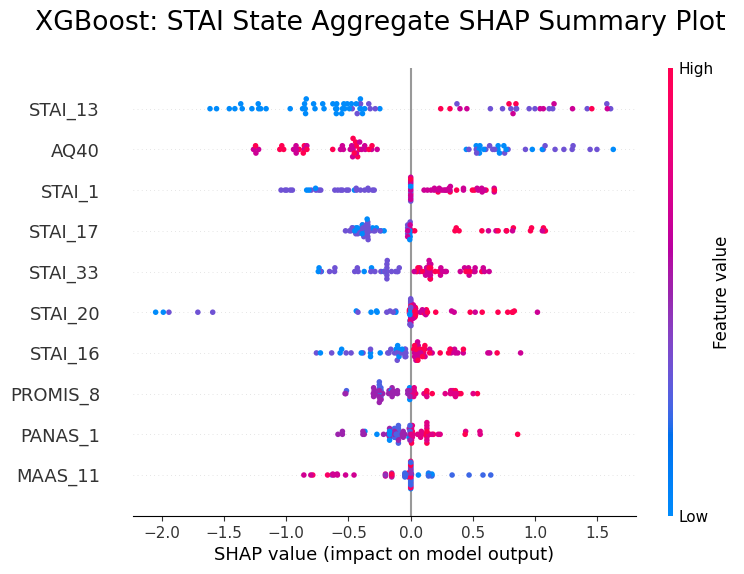

In [13]:
import shap
feature_names = X.columns
all_shap_values = []
all_X_test = []

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, valid_index in cv_inner.split(X, y_state):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_state[train_index], y_state[valid_index]

    # xgb_model = best_est[9].named_steps['model']
    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1,
                                  gamma= 0,
                                  learning_rate=0.05,
                                  max_depth= 5,
                                  reg_alpha=0,
                                  reg_lambda=0.05,
                                  eval_metric = 'auc',
                                  n_estimators = 1000)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
combined_X_test = pd.concat(all_X_test)

# Generate the aggregated summary plot
shap.summary_plot(combined_shap_values, combined_X_test, max_display=10, show=False)
plt.title("XGBoost: STAI State Aggregate SHAP Summary Plot \n")
plt.show()


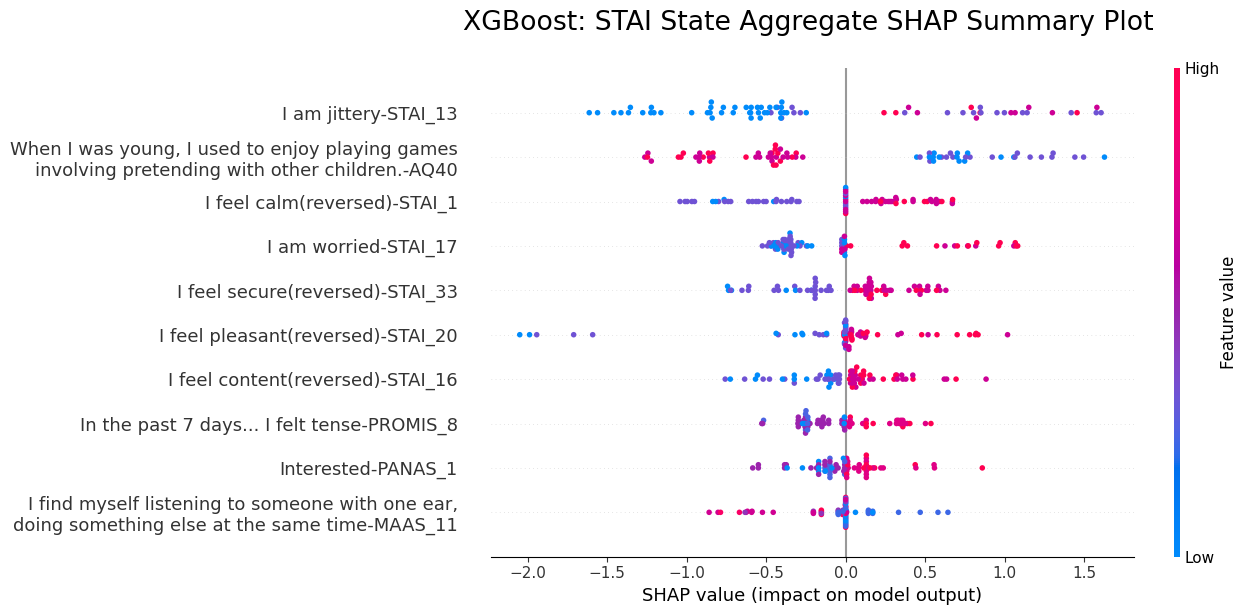

In [15]:
import os
import pandas as pd
import shap
import json
import matplotlib.pyplot as plt
import textwrap

def wrap_labels(labels, width=50):
    return [textwrap.fill(label, width) for label in labels]

# Load the mapping file
with open("/content/Questionnaire_names.json", 'r') as f:
    result = json.load(f)

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
original_X_test_df = pd.concat(all_X_test)

# Generate new column names
final_column_names = []
for col in original_X_test_df.columns:
    mapped_name = result.get(col, col) # Get mapped name, or original if not found
    if re.search(r'\d', col): # Check if the original column name contains a digit
        final_column_names.append(f"{mapped_name}-{col}")
    else:
        final_column_names.append(mapped_name)

# Assign the new column names to the DataFrame used for plotting
combined_X_test = original_X_test_df.copy() # Create combined_X_test with new column names
combined_X_test.columns = final_column_names

# Wrap the newly created feature names for better display in the plot
wrapped_feature_names = wrap_labels(combined_X_test.columns)

# Assuming combined_shap_values are defined
shap.summary_plot(combined_shap_values, combined_X_test, feature_names=wrapped_feature_names, max_display=10, show=False)
plt.title("XGBoost: STAI State Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)

# Save the plot as an SVG file
plt.gcf().set_size_inches(12,6)
plt.savefig('/content/drive/MyDrive/Mindful_Inter_Autism_Data/XGB_STATE_SHAP_summary_plot2.svg', format='svg', bbox_inches='tight')

plt.show()

# --------

# **TRAIT w/ Pipeline + GridSearch CV**

In [ ]:
best_est = []
NestedCV(X, y_trait)

Best Param: {'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__reg_alpha': 0, 'model__reg_lambda': 0}, AUC Score: 0.5000
Best Param: {'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0}, AUC Score: 0.3750
Best Param: {'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__reg_alpha': 0.05, 'model__reg_lambda': 0}, AUC Score: 0.6250
Best Param: {'model__gamma': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1}, AUC Score: 0.8750
Best Param: {'model__gamma': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1}, AUC Score: 0.3750
Best Param: {'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__reg_alpha': 0.05, 'model__reg_lambda': 0}, AUC Score: 0.6667
Best Param: {'model__gamma': 0, 'model__learning_rate': 0.01, 'model__ma

In [ ]:
aucs = []
n_folds = 5
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for estimator in best_est:
    for train_index, valid_index in cv_inner.split(X, y_trait):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y_trait[train_index], y_trait[valid_index]

        X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

        model = estimator.named_steps['model']
        model.fit(X_tr_scaled, y_tr)
        pred = model.predict(X_val_scaled)
        pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc_score = roc_auc_score(y_val, pred_proba)

        aucs.append(auc_score)
    avg_auc = sum(aucs) / len(aucs)
    stdev = np.std(aucs)

    # 95% confidence interval using t-distribution
    ci_low, ci_high = st.t.interval(0.95,
        df=n_folds - 1,
        loc=avg_auc,
        scale=stdev / np.sqrt(n_folds)
    )
    # print(f"Params = {model}")
    print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    aucs.clear()

AUC = 0.4417 | Stdev = 0.1413 | 95% CI = [0.2663, 0.6171]
AUC = 0.4305 | Stdev = 0.1858 | 95% CI = [0.1998, 0.6612]
AUC = 0.4589 | Stdev = 0.1605 | 95% CI = [0.2597, 0.6582]
AUC = 0.4685 | Stdev = 0.1391 | 95% CI = [0.2957, 0.6412]
AUC = 0.4474 | Stdev = 0.1413 | 95% CI = [0.2720, 0.6229]
AUC = 0.4354 | Stdev = 0.1610 | 95% CI = [0.2355, 0.6352]
AUC = 0.4573 | Stdev = 0.1560 | 95% CI = [0.2636, 0.6510]
AUC = 0.4354 | Stdev = 0.1610 | 95% CI = [0.2355, 0.6352]
AUC = 0.4576 | Stdev = 0.1403 | 95% CI = [0.2834, 0.6318]
AUC = 0.4536 | Stdev = 0.1477 | 95% CI = [0.2702, 0.6370]


## model 4

## **Aggregate Feature Importances**

In [ ]:
aucs = []
feature_names = X.columns
counter = 0

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    xgb_model = best_est[3].named_steps['model']

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)
    pred = xgb_model.predict(X_val_scaled)
    pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, pred_proba)

    aucs.append(auc_score)

    # feature importances
    importances = xgb_model.feature_importances_
    feature_importance = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_importance = feature_importance.sort_values(by='importances', ascending=False)

    feature_odds = pd.DataFrame(importances, index=feature_names,
                             columns=['importances'])
    feature_odds = feature_odds.sort_values(by='importances', ascending=False)

    if counter == 0:
      fi_df = feature_importance.copy()
      counter += 1
    else:
      fi_df = pd.concat([fi_df,feature_importance], axis=1)

avg_auc = sum(aucs) / len(aucs)
stdev = np.std(aucs)
aucs.clear()

In [ ]:
n_folds = 5

# 95% confidence interval using t-distribution
ci_low, ci_high = st.t.interval(
    0.95,
    df=n_folds - 1,
    loc=avg_auc,
    scale=stdev / np.sqrt(n_folds)
)

print(f"{best_est[8].named_steps['model']}")
print(f"AUC = {avg_auc:.4f} | Stdev = {stdev:.4f} | 95% CI = [{ci_low:.4f}, {ci_high:.4f}]")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)
AUC = 0.4685 | Stdev = 0.1391 | 95% CI = [0.2957, 0.6412]


In [ ]:
fi_df_copy = fi_df.copy()

fi_df_copy = fi_df_copy.groupby(fi_df_copy.columns, axis=1).sum()
save_to_drive = fi_df_copy.sort_values(by=['importances'], ascending=False).head(10)
# save_to_drive.to_csv('/content/drive/MyDrive/Mindful_Inter_Autism_Data/Feature Importances/XGB_TRAIT_fi.csv', index=True)
save_to_drive

/tmp/ipython-input-2591718807.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).sum()


,importances
STAI_1,0.133974
FFMQ_1,0.127173
MAAS_2,0.116950
MAAS_11,0.109910
MAAS_12,0.108317
FFMQ_9,0.103415
MAAS_8,0.085242
AQ24,0.083903
DA_social_anxiety,0.081158
AQ_baseline,0.080568


## **Calibration Curve**

In [ ]:
xgb_kfold_probability = []
true_labels = []

from sklearn.calibration import calibration_curve
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1,
                                  gamma= 0,
                                  learning_rate=0.05,
                                  max_depth= 5,
                                  reg_alpha=0,
                                  reg_lambda=0.05,
                                  eval_metric = 'auc',
                                  n_estimators = 1000)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)
    pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
    xgb_kfold_probability.append(pred_proba)
    true_labels.append(y_val)

    # Compute the calibration curve using 20 bins.
    mean_predicted_value, true_fraction_of_positives = calibration_curve(
        y_val,
        pred_proba,
        n_bins=20,
        strategy="uniform",
    )

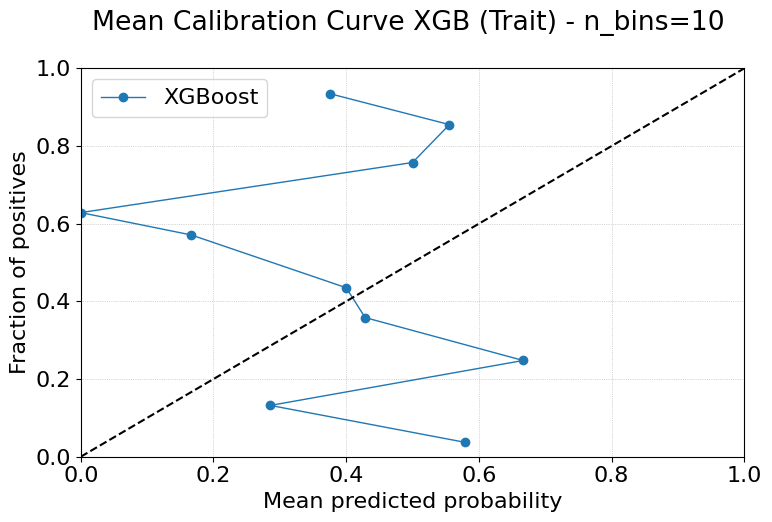

In [ ]:
xgb_kfold_probability_stacked = np.hstack(xgb_kfold_probability)
true_labels_stacked = np.hstack(true_labels)
xgb_y, xgb_x = calibration_curve(true_labels_stacked, xgb_kfold_probability_stacked, n_bins=10)

# calibration curves
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(xgb_y, xgb_x, marker='o', linewidth=1, label='XGBoost')
ax.set(
    title="Mean Calibration Curve XGB (Trait) - n_bins=10 \n",
    xlabel="Mean predicted probability",
    ylabel="Fraction of positives",
    xlim=(0, 1),
    ylim=(0, 1),
)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

import matplotlib.lines as mlines
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], linestyle="--", color="black")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.legend()
plt.show()

## **SHAP Values**

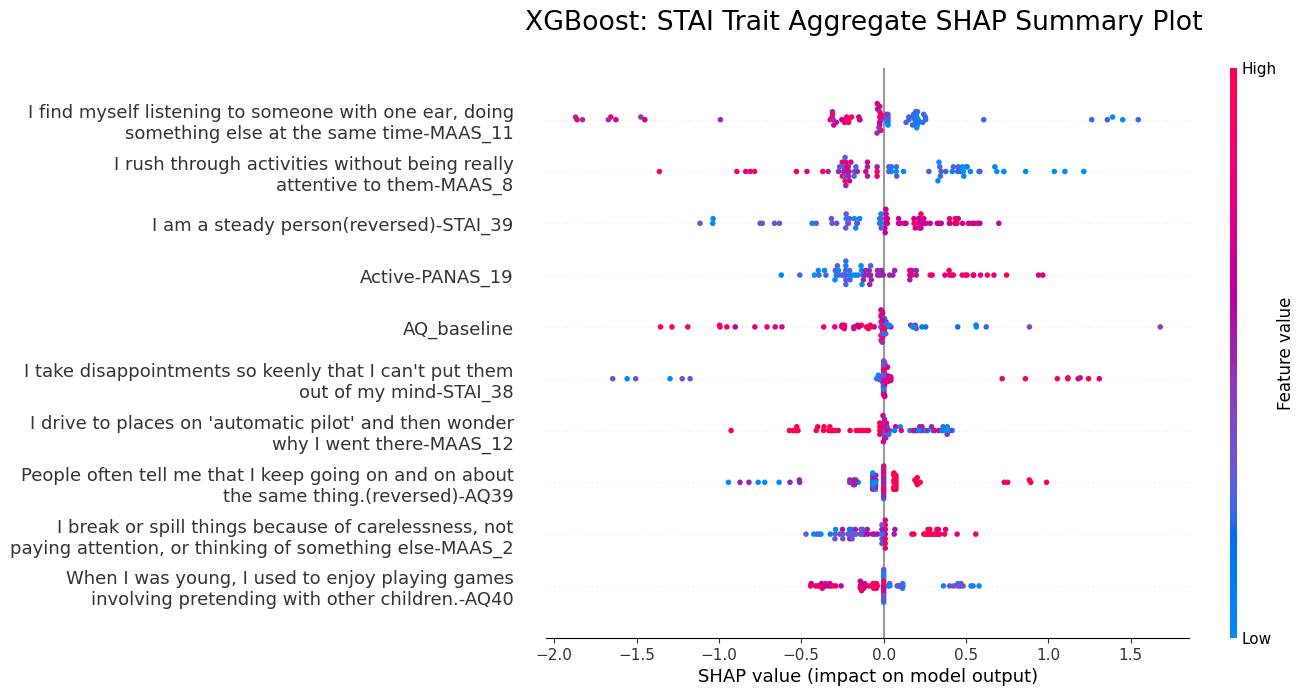

In [17]:
all_shap_values = []
all_X_test = []

for train_index, valid_index in cv_inner.split(X, y_trait):
    X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_tr, y_val = y_trait[train_index], y_trait[valid_index]

    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1,
                                  gamma= 0,
                                  learning_rate=0.05,
                                  max_depth= 5,
                                  reg_alpha=0.1,
                                  reg_lambda=0,
                                  eval_metric = 'auc',
                                  n_estimators = 1000)

    X_tr_scaled, X_val_scaled = Standardize_data(X_tr, X_val)

    xgb_model.fit(X_tr_scaled, y_tr)

    #SHAP
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_val_scaled)
    all_shap_values.append(shap_values)
    all_X_test.append(X_val_scaled)

def wrap_labels(labels, width=55):
    return [textwrap.fill(label, width) for label in labels]

# Combine SHAP values and X_test from all folds
combined_shap_values = np.vstack(all_shap_values)
original_X_test_df = pd.concat(all_X_test)

# Generate new column names
final_column_names = []
for col in original_X_test_df.columns:
    mapped_name = result.get(col, col) # Get mapped name, or original if not found
    if re.search(r'\d', col): # Check if the original column name contains a digit
        final_column_names.append(f"{mapped_name}-{col}")
    else:
        final_column_names.append(mapped_name)

# Assign the new column names to the DataFrame used for plotting
combined_X_test = original_X_test_df.copy()
combined_X_test.columns = final_column_names

# Wrap the newly created feature names for better display in the plot
wrapped_feature_names = wrap_labels(combined_X_test.columns)

# Assuming combined_shap_values are defined
shap.summary_plot(combined_shap_values, combined_X_test, feature_names=wrapped_feature_names, max_display=10, show=False)
plt.title("XGBoost: STAI Trait Aggregate SHAP Summary Plot \n")
plt.subplots_adjust(left=0.3)

# Save the plot as an SVG file
plt.gcf().set_size_inches(12,7)
plt.savefig('/content/drive/MyDrive/Mindful_Inter_Autism_Data/XGB_TRAIT_SHAP_summary_plot.svg', format='svg', bbox_inches='tight')
plt.show()
